In [1]:
import pandas as pd
import numpy as np
import time
import gc
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
# from s3fs.core import S3FileSystem
from tqdm import tqdm

def draw_screen_poly(lats, lons, map):
    x, y = map( lons, lats )
    xy = zip(x,y)
    poly = Polygon(list(xy), 
                   edgecolor="black",
                   facecolor="None",
                   lw=2.5)
    plt.gca().add_patch(poly)

def global_map_plot(df, variable, vmin, vmax, cmap, title):
    # get new coordinate
    df["lon_new"] = np.where(df['lon'] <= 180, df['lon'], df['lon']-360)
        # Midwest US
    # https://en.wikipedia.org/wiki/Module:Location_map/data/USA_Midwest
    lats_mw_us = [ 36.15, 49.5, 49.5, 36.15 ]
    lons_mw_us = [ -95, -95, -75, -75 ]

    # Europe
    lats_eu = [ 40, 50, 50, 40 ]
    lons_eu = [ 15, 15, 30, 30 ]

    # India https://link.springer.com/article/10.1007/s12524-011-0119-x
    # Just say central India and the indo gangetic plains 
    lats_in = [ 18, 25, 25, 18 ]
    lons_in = [ 75, 75, 87, 87 ]

    # https://baike.baidu.com/item/%E5%8D%8E%E5%8C%97%E5%B9%B3%E5%8E%9F
    lats_ch = [ 32, 45, 45, 32 ]
    lons_ch = [ 110, 110, 123, 123 ]
    
    
    plt.figure(figsize=(15, 7))
    map = Basemap(llcrnrlon=-180,llcrnrlat=-60,urcrnrlon=180,urcrnrlat=75)
    map.drawcoastlines()
    map.drawcountries()
    map.drawlsmask(ocean_color="aqua",
                   resolution = 'l')
    map.drawmeridians(range(0, 360, 30),labels=[True,False,False,True],fontsize=20)
    map.drawparallels(range(-90, 100, 30), labels=[True,False,False,True],fontsize=20)
    draw_screen_poly(lats_mw_us, lons_mw_us, map)
    draw_screen_poly(lats_eu, lons_eu, map)
    draw_screen_poly(lats_in, lons_in, map)
    draw_screen_poly(lats_ch, lons_ch, map)
    
    if cmap == "bwr":
        map.fillcontinents(zorder=0)
    plt.scatter(df["lon_new"], df["lat"], 
                c=df[variable],
                s=6, cmap=cmap, vmin=vmin, vmax=vmax)
    clb = plt.colorbar(orientation="vertical",fraction = 0.023, pad=0.01)
    clb.ax.tick_params(labelsize=20)
    #plt.colorbar(orientation="horizontal",fraction=0.046, pad=0.1)
    #plt.savefig("./"+title+"_rmse.pdf")
    plt.show()

## Save the necessary files

In [2]:
%%time

# s3 = S3FileSystem()
validation_path = "/glade/scratch/zhonghua/CESM_validation_min/"
save_dir = "/glade/scratch/zhonghua/model-validation-diff_min/"
diff_by_lat_lon_ls = []

for i in tqdm(range(2,34)):
        member = (str(i).zfill(3))
        #print("member:",member)

        df_2006=pd.read_csv(validation_path+"2006/"+member+"_ens.csv")
        diff_by_lat_lon_2006 = df_2006.groupby(["lat","lon"])\
                                   .apply(lambda df_2006: 
                                          np.mean(df_2006[member]-df_2006["TREFMNAV_U"]))

        df_2061=pd.read_csv(validation_path+"2061/"+member+"_ens.csv")
        diff_by_lat_lon_2061 = df_2061.groupby(["lat","lon"])\
                                   .apply(lambda df_2061: 
                                          np.mean(df_2061[member]-df_2061["TREFMNAV_U"]))
        
        diff_by_lat_lon_ls.append(diff_by_lat_lon_2061 - diff_by_lat_lon_2006)
        
        del df_2006, df_2061, diff_by_lat_lon_2006, diff_by_lat_lon_2061
        gc.collect()
        
diff_by_lat_lon=pd.concat(diff_by_lat_lon_ls,axis=1)
diff_by_lat_lon.to_csv(save_dir+"diff_by_lat_lon.csv")

100%|██████████| 32/32 [12:40<00:00, 23.75s/it]


CPU times: user 11min 9s, sys: 1min 23s, total: 12min 33s
Wall time: 12min 40s


## visualization

In [3]:
# s3 = S3FileSystem()
validation_path = "/glade/scratch/zhonghua/CESM_validation_min/"
save_dir = "/glade/scratch/zhonghua/model-validation-diff_min/"
df = pd.read_csv(save_dir+"diff_by_lat_lon.csv")
df_mean = df.set_index(["lat","lon"]).mean(axis=1)

,lat,lon,0,1,2,3,4,5,6,7,...,22,23,24,25,26,27,28,29,30,31
count,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,...,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000
mean,23.864969,131.385729,-0.000425,-0.000142,-0.002258,-0.015421,0.005643,-0.005536,0.000078,-0.001374,...,0.004479,0.004285,0.003356,-0.000062,-0.005141,0.005951,-0.005599,-0.002148,-0.006156,0.004184
std,25.646228,111.895429,0.043288,0.043039,0.042202,0.049540,0.041642,0.042715,0.038633,0.043176,...,0.040755,0.043728,0.043374,0.044401,0.040565,0.040723,0.042405,0.038852,0.043511,0.041213
min,-54.188499,0.000000,-0.216134,-0.248842,-0.194399,-0.280961,-0.239959,-0.253616,-0.189848,-0.338982,...,-0.210539,-0.192220,-0.173805,-0.241237,-0.194014,-0.174080,-0.198652,-0.212791,-0.198928,-0.243844
25%,8.952900,36.250000,-0.025523,-0.024939,-0.025487,-0.043420,-0.019682,-0.027858,-0.021490,-0.023114,...,-0.019596,-0.019260,-0.023222,-0.024103,-0.027777,-0.017950,-0.029719,-0.024484,-0.029918,-0.018400
50%,29.685900,100.000000,-0.000637,-0.000506,-0.000985,-0.009346,0.003483,-0.003343,0.000568,0.000190,...,0.003611,0.004435,0.001906,0.001434,-0.002498,0.005519,-0.003824,-0.000947,-0.004862,0.004822
75%,42.879601,260.000000,0.023862,0.022981,0.021292,0.016430,0.028673,0.018615,0.022604,0.021673,...,0.027003,0.027514,0.027963,0.025827,0.018589,0.029325,0.019115,0.021461,0.018893,0.028694
max,70.209396,358.750000,0.219017,0.218518,0.175397,0.177260,0.221255,0.171071,0.177782,0.277881,...,0.201947,0.278051,0.206665,0.193029,0.176814,0.196835,0.188517,0.225064,0.227406,0.178026


count    4439.000000
mean       -0.000693
std         0.011869
min        -0.109174
25%        -0.007226
50%         0.000017
75%         0.006309
max         0.063234
dtype: float64

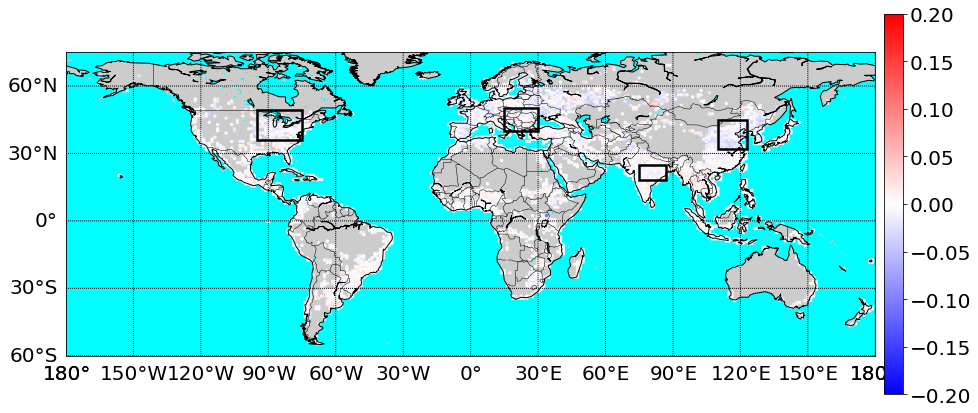

In [4]:
display(df.describe())
display(df_mean.describe())
global_map_plot(df_mean.reset_index(), 0, -0.2, 0.2, "bwr","")